In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import glob
import pandas as pd
import cvlib as cv
import time

from util import *

In [2]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


# Loading of data

In [3]:
# loading labels from csv file
df = pd.read_csv("Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = df.breed.unique()
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10222 non-null  object
 1   breed     10222 non-null  object
 2   breed_id  10222 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 239.7+ KB


In [5]:
# preview of data
df.head(n=20)

,id,breed,breed_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,5
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,5
7,002a283a315af96eaea0e28e7163b21b,borzoi,6
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,8


In [6]:
dict_breeds['rottweiler']

119

## Preparing for training data
* as the given images are all in jpg format, maybe can try just append directory and extension to panda dataframe, then a simple loop to load image
* shuffle may not be necessary as `train_test_split` function will assit you for that
```python
# following not needed
random.seed(42)
random.shuffle(image_files_train)
# split helps you shuffle the data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
```

In [7]:
# hyperparameters 
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

In [8]:
# should be disable when testing on other models (image dimension maybe different)
enable_load_saved = True;
saved_file = "precessed_data"
    
data = []
labels = []
start = time.time()
if (enable_load_saved and os.path.isfile(saved_file+".h5")):
    print("loading from h5 file")
    data, labels = load_h5_data(saved_file+".h5")
    
else:
    print("h5 file is not exist or loading from h5 is disabled")
    # collect all files from directory into a list
    image_files_train = [f for f in glob.glob("Datasets/train" + "/**/*", recursive=True) if not os.path.isdir(f)]
    print("{} files found!".format(len(image_files_train)))
    
    # create groud-truth label from the image path
    print("loading images")
    for img in image_files_train:
        img_file = os.path.basename(img)
        name = img_file.split(".")[0]

        # check if image file has a record in given labels
        result = df.loc[df['id'] == name]
        if result.empty:
            print("LABEL NOT FOUND: {}".format(name))
            continue
        else:
            # reading of image (cv2 load the image with BGR channels, when preview need to convert back to RGB channels)
            image = cv2.imread(img)
            image = cv2.resize(image, (img_dims[0],img_dims[1]))
            image = img_to_array(image)
            data.append(image)

            # read respective unique breed id from result 
            label = result['breed_id'].iloc[0]
            labels.append([label])
            
    # pre-processing (normalisation)
    print("pre-processing")
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    
    print('x_data shape:', data.shape)
    print('y_data shape:', labels.shape)
    
    # saving for future uses
    generate_h5_data(data, labels, saved_file)
end = time.time()
print("time taken "+time_convert(end-start))

loading from h5 file
The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (10222, 96, 96, 3)
The shape of y_field (10222, 1)
time taken  1s


(10222, 96, 96, 3)


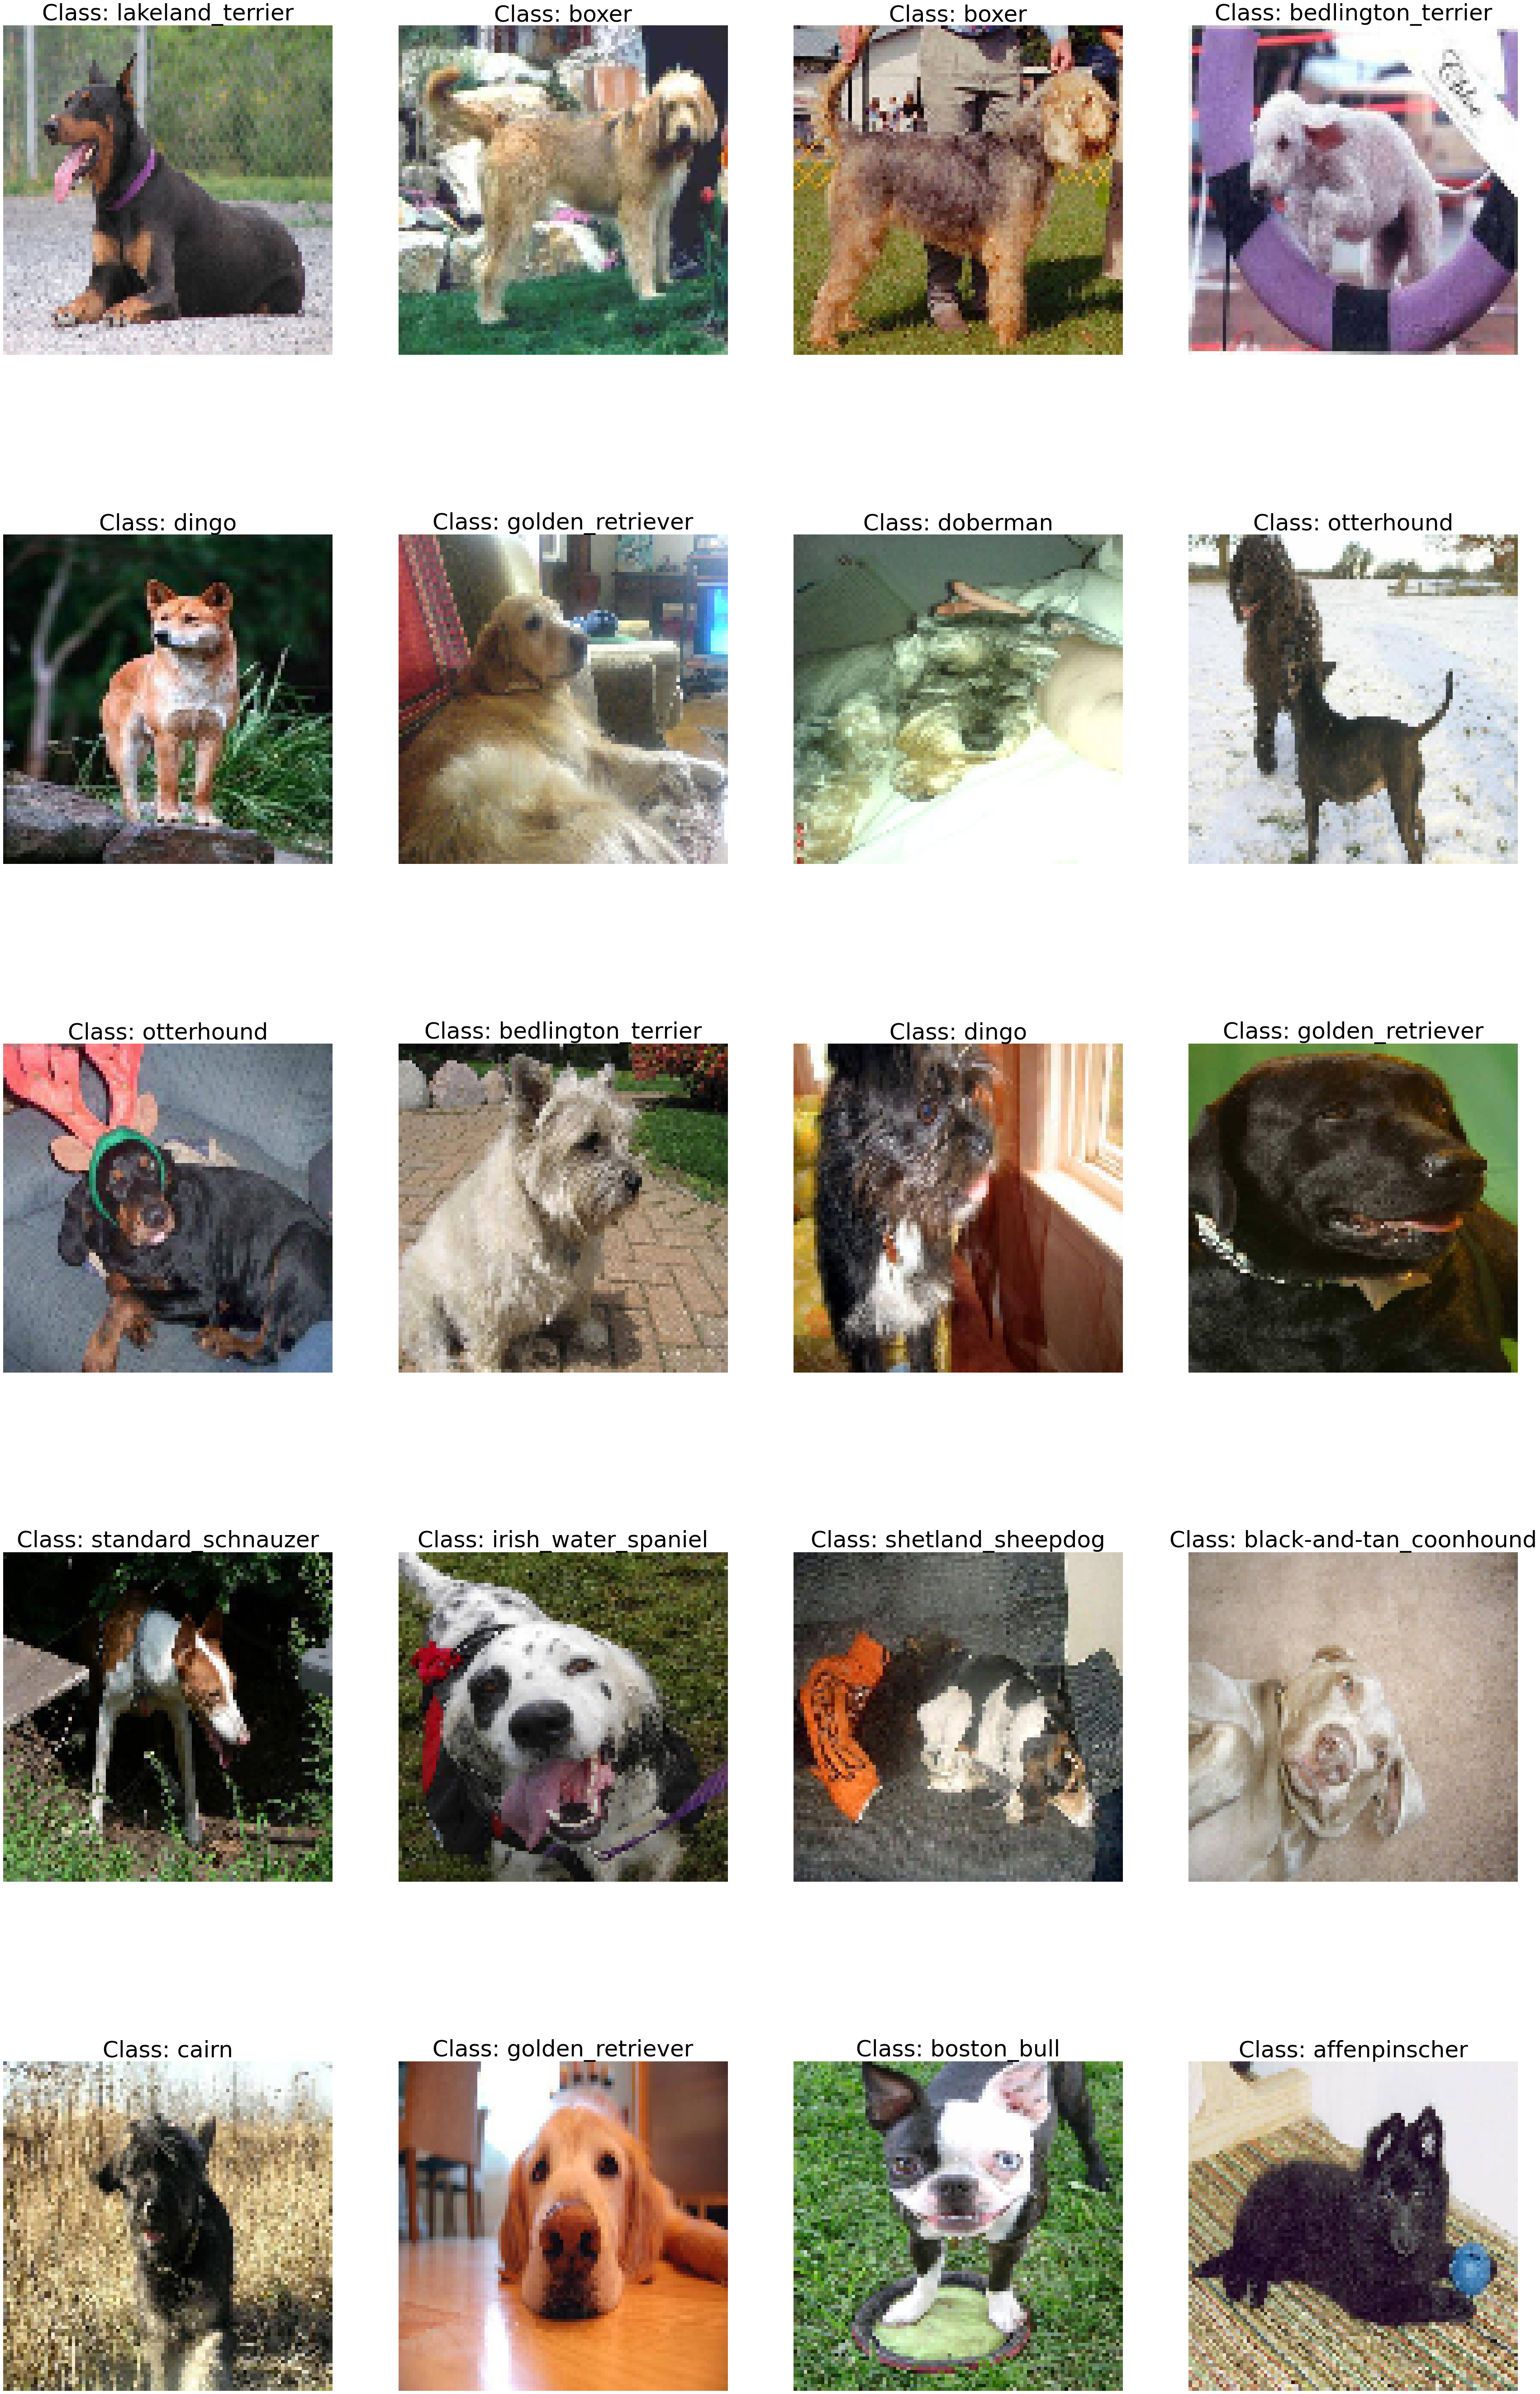

In [9]:
show_20_images(df, data, labels, 20)

# Train

In [10]:
x=labels[20]
print(int(x))

18


In [11]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [12]:
# with open('trainout.txt', 'w') as f:
#     for item in labels:
#         f.write("%s\n" % item)

In [13]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=120)
testY = to_categorical(testY, num_classes=120)

In [14]:
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_rate = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

In [15]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# build model
model = SmallerVGGNet.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=120)
# compile the model, need to reduce lr to reduce overfit
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="CategoricalCrossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
start = time.time()
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1,
                        callbacks=[lr_rate]
                       )
end = time.time()

# save the model to disk
model.save("my_model2")

print("training time: "+time_convert(end-start))

C:\Users\chiayu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
127/127 [==============================] - 32s 181ms/step - loss: 5.6890 - accuracy: 0.0181 - val_loss: 5.9445 - val_accuracy: 0.0108
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
127/127 [==============================] - 12s 91ms/step - loss: 4.9406 - accuracy: 0.0353 - val_loss: 5.6579 - val_accuracy: 0.0205
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
127/127 [==============================] - 12s 91ms/step - loss: 4.7830 - accuracy: 0.0435 - val_loss: 5.7124 - val_accuracy: 0.0284
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
127/127 [==============================] - 12s 91ms/step - loss: 4.6687 - accuracy: 0.0566 - val_loss: 4.8798 - val_accuracy: 0.0421
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001

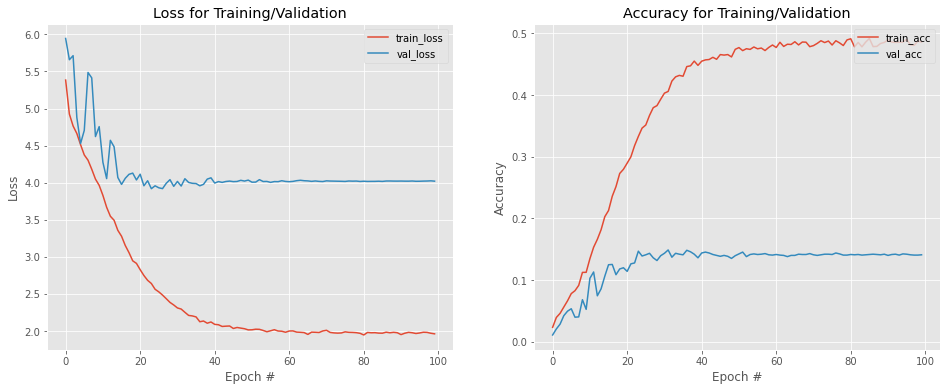

In [16]:
plot_model_history(H, saving_name="model_loss_acc")

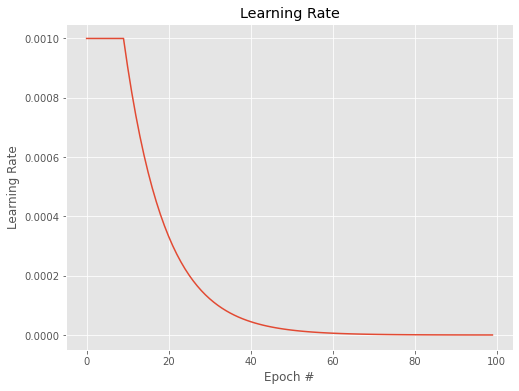

In [17]:
plot_learning_rate(H, saving_name="model_lr")